# Time Series Analysis with Statsmodels

I recommend using venv to set up virtual environments. These are isolated Python installations and then you won't run into conflicts there.

To setup, type "python3 -m venv <envname>". To activate type ". <envname>/bin/activate" (the "." reads the contents into the shell which sets up the proper environment variables.) If you want to leave type "deactivate".

In this notebook, we set up a simple model of ARMA data, and then do some analysis with statsmodels.

Prior to running this, install pandas, numpy, and matplotlib, and statsmodels. To see this notebook, install jupyter. Then, go to this directory and type "jupyter notebook" and you can open the notebook.

Execute lines by shift+Return.

# Setting up some ARMA data

First, let us use arma_generate_sample from statsmodels to create some data with known ARMA signature. Note that not all parameter choices give rise to stationary time series. In particular, there is a chance that the time series explodes over time.

First, import everything we need.

In [1]:
%matplotlib inline
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/Users/mibraun/ts/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now set up the model. The first argument are the AR coefficient, the second the MA coefficients. Note that both also include the zero lag coefficients, that is, the value of the time series at the point you are looking at right now, so you'd usually want to set them to 1.0.

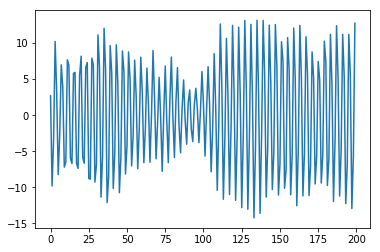

In [2]:
from statsmodels.tsa.arima_process import arma_generate_sample
x = arma_generate_sample([1.0, -0.6, 1.0, -0.6], [1.0], 200, 1.0, burnin=100)
plt.plot(x)

# Plotting the ACF and PACF

The autocorrelation function and the partial autocorrelation function are standard tools to analyze the time structure and guide the selection of the orders of the ARMA process.

In order to get them both into one plot, we are first setting up a figure, and then putting two subplots in there.

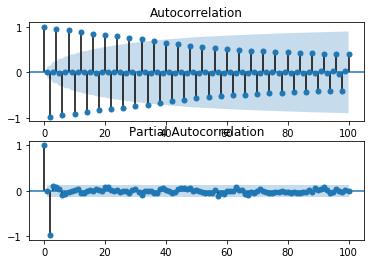

In [3]:
f = plt.figure()
ax = f.add_subplot(2,1,1); _ = sm.graphics.tsa.plot_acf(x, lags=100, ax=ax)
ax2 = f.add_subplot(2,1,2); _ = sm.graphics.tsa.plot_pacf(x, lags=100, ax=ax2)



# Training an ARMA model with statsmodels

Now we come the actual training of the model. The approach is always the same: construct the model by passing the data and model parameters, call fit() on the model to obtain the result object.

If you change the data or parameters to play around later, don't be alarmed if you run into error messages, for example that the initial AR coefficients aren't stationary, or that the method could not converge. Depending on the data, it might actually be that the resulting process is not stable (but explodes).

Consult the documentation for the fit function to see what other solvers or models exist.

In [4]:
model = sm.tsa.ARMA(x, (3, 1))
result = model.fit(maxiter=1000, method='mle', solver='cg')
result.summary()

Optimization terminated successfully.
         Current function value: 1.457367
         Iterations: 64
         Function evaluations: 145
         Gradient evaluations: 145


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                     ARMA(3, 1)   Log Likelihood                -291.473
Method:                           mle   S.D. of innovations              1.017
Date:                Thu, 28 Sep 2017   AIC                            594.947
Time:                        11:42:52   BIC                            614.737
Sample:                             0   HQIC                           602.955
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0686      0.073      0.937      0.350      -0.075       0.212
ar.L1.y        0.4843      0.116      4.173      0.000       0.257       0.712
ar.L2.y       -0.9934      0.007   -149.798      0.000      -1.006      -0.980
ar.L3.y        0.4821      0.115      4.187      0.000       0.256       0.708
ma.L1.y        0.0445      0.131      0.340      0.734      -0.212       0.301
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.0004           -1.0031j            1.0031           -0.2501
AR.2           -0.0004           +1.0031j            1.0031            0.2501
AR.3            2.0613           -0.0000j            2.0613           -0.0000
MA.1          -22.4504           +0.0000j           22.4504            0.5000
-----------------------------------------------------------------------------
"""

Now we can plot the predictions. I assign to a dummy variable here, otherwise we end up with two plots in matplotlib.

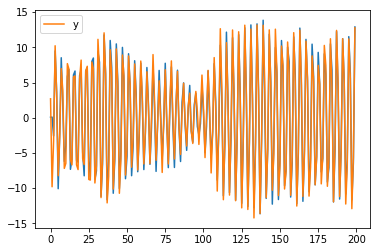

In [5]:
_ = result.plot_predict()

The result object has the residuals as an attribute. It is just an array that can be further plotted or analyzed.

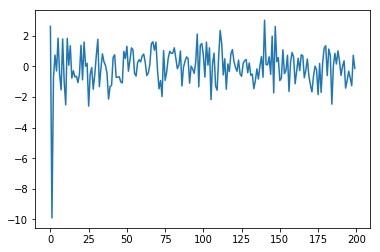

In [6]:
plt.plot(result.resid)

In this case, the errors are not zero, but okay compared to the signal. Also note that the process did have an MA component which means there is systematic error in the measurement and you cannot expect that they are zero.

The plot_predict method has a number of options, in particular start to control from when point on you want to see the predictions. Another is dynamic to decide whether you want to use the predictions as input for the models (if set to True). This usually results in much more unstable predictions, but these can be made without any access to actual future data.

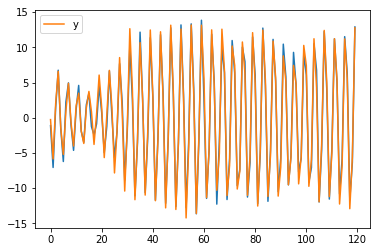

In [7]:
_ = result.plot_predict(start=80, plot_insample=True)

Another method is forecast which extends the forecast beyond the data that the model has been trained on. It returns the actual forecast, the standard error, and lower and upper confidence intervals for the forecast.

In [8]:
f, s, e= result.forecast(steps=50)

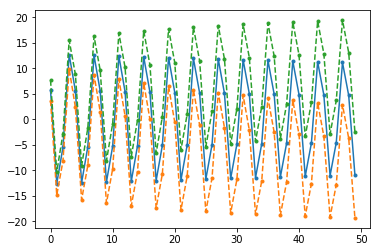

In [9]:
plt.plot(f, '.-', e, '.--')